# Common Characters of HSK and JLPT 

In this notebook we explore how much Chinese and Japanese characters do overlap. In particular, we want to evaluate the overlap at different levels of fluency. In other words, if a Japanese learner starts studying Chinese, how many characters would the student know?

In this work, we measure the levels of fluency based on Hanyu Shuiping Kaoshi (HSK) for Chinese, and Japanese-Language Proficiency Test (JLPT), for Japanese.


## Load Data

The JLPT data has been obtained from http://www.tanos.co.uk and the info of HSK can be found in  http://www.hanzidb.org/about


In [1]:
import numpy as np
import pandas as pd 

In [2]:
HSK_characters = pd.read_csv("data/character_hsk",sep="|",header=None, names=["character","HSK"], dtype=str)
JLPT_vocab = pd.read_csv('data/JLPT_vocab.txt', header = None, sep="\t", names=["kanji","hiragana","English","grade"])

### Japanese Dataset Preprocessing
The JLPT dataset does not contain charucters but complete words. Therefore we split the words into characters, remove hiragana/katakana and asign the JLPT level to each character.

In [3]:
#remove the hiragana and katakana and convert the word to a set of kanjis
hiragana_set = set("".join(JLPT_vocab["hiragana"].tolist())) 
JLPT_kanji_set = JLPT_vocab["kanji"].astype(str).apply(lambda x:  set(x) - hiragana_set )

#get pairs of [kanji,grade]
kanji_set=pd.concat([JLPT_kanji_set,JLPT_vocab["grade"]], axis=1)
kanji_grade_list_nested=kanji_set.apply(lambda row: [[x,row['grade']] for x in list(row['kanji'])], axis=1).tolist()
#flatten the list
kanji_grade_list=[item for sublist in kanji_grade_list_nested for item in sublist]

#store in a dictionary where each kanji has the highest (easiest) JLPT grade
kanji_grade_dict=dict()
for x in kanji_grade_list:
    [kj,gr]=x
    kj_grade=kanji_grade_dict.get(kj,0)
    new_grade=max(kj_grade,gr)
    kanji_grade_dict[kj]=new_grade

#convert to pandas
JLPT_characters=pd.DataFrame(kanji_grade_dict.items()).astype(str)
JLPT_characters.columns = ['character', 'JLPT']

#show head
JLPT_characters.head()

,character,JLPT
0,会,5
1,青,5
2,赤,5
3,明,5
4,秋,5


### Chinese Dataset Preprocessing

We add the traditional characters to the Chinese dataset 

In [4]:
from hanziconv import HanziConv

HSK_characters["traditional"]=HSK_characters["character"].apply(lambda x: HanziConv.toTraditional(x))
HSK_characters.head()

,character,HSK,traditional
0,漂,1,漂
1,土,5,土
2,圈,5,圈
3,歉,4,歉
4,歇,5,歇


### Join Datasets
Join the data of HSK and JLPT to build a single dataset containing the grades in both languages. We create one dataset using simplified characters and another with traditional.

In [5]:
character_grades = JLPT_characters.merge(HSK_characters,left_on = 'character', right_on = 'character' ,how="outer")[["character", "JLPT",  "HSK"]]

In [6]:
# Do a left join with traditional characters
character_grades_trad= character_grades.merge( HSK_characters, left_on = 'character', right_on = 'traditional' , how="left" )
#use the highst hsk (that which is not NaN)
highest_hsk= character_grades_trad[['HSK_x','HSK_y']].fillna("0").astype("int").max(axis=1 ).replace(0,np.nan, inplace=False) #.astype("int")
character_grades_trad['HSK']=highest_hsk
character_grades_trad=character_grades_trad[["character_x", "JLPT",  "HSK"]].rename(columns={"character_x": "character"})

## Some Statistics

### Total characters

In [7]:
print("Number of total characters in HSK: "+str(len(HSK_characters)))
print("Number of total kanji in JLPT: "+str(len(JLPT_characters)))

Number of total characters in HSK: 2636
Number of total kanji in JLPT: 2090


### Characters by level

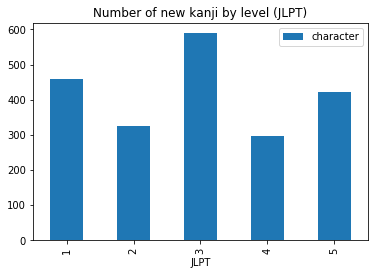

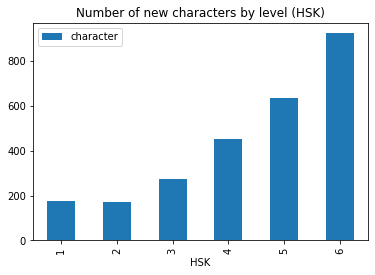

In [8]:
import matplotlib.pyplot as plt

JLPT_characters.groupby(by='JLPT').agg('count').plot(kind='bar', title="Number of new kanji by level (JLPT)")
plt.show()

HSK_characters.groupby(by='HSK').agg('count')[["character"]].plot(kind='bar', title="Number of new characters by level (HSK)")
plt.show()

### Unique characters

Characters in HSK and JLPT: 1147
Characters only in HSK: 1489
Characters only in JLPT: 943


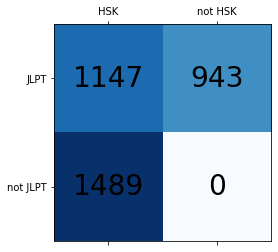

In [9]:
from sklearn.metrics import confusion_matrix

print("Characters in HSK and JLPT: "+str(len(character_grades[character_grades["JLPT"].notna() & character_grades["HSK"].notna()])) )
print("Characters only in HSK: "+str(len(character_grades[character_grades["JLPT"].isna() & character_grades["HSK"].notna()])) )
print("Characters only in JLPT: "+str(len(character_grades[character_grades["JLPT"].notna() & character_grades["HSK"].isna()])) )

conf_mat=confusion_matrix(
    character_grades["JLPT"].isna().tolist(),
    character_grades["HSK"].isna().tolist() 
    )


fig, ax = plt.subplots()
ax.matshow(conf_mat, cmap='Blues')
for (i, j), z in np.ndenumerate(conf_mat):
    ax.text(j, i, '{:0.0f}'.format(z), ha='center', va='center', fontsize=28)

ax.set_xticklabels(['', 'HSK', 'not HSK'])
ax.set_yticklabels(['', 'JLPT', 'not JLPT'])

plt.show()


Characters (traditional) in HSK and JLPT: 1560
Characters (traditional) only in HSK: 1489
Characters (traditional) only in JLPT: 531


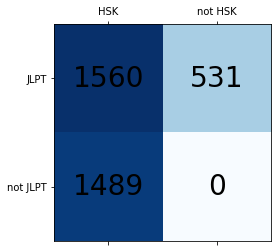

In [10]:
print("Characters (traditional) in HSK and JLPT: "+str(len(character_grades_trad[character_grades_trad["JLPT"].notna() & character_grades_trad["HSK"].notna()])) )
print("Characters (traditional) only in HSK: "+str(len(character_grades_trad[character_grades_trad["JLPT"].isna() & character_grades_trad["HSK"].notna()])) )
print("Characters (traditional) only in JLPT: "+str(len(character_grades_trad[character_grades_trad["JLPT"].notna() & character_grades_trad["HSK"].isna()])) )

conf_mat_trad=confusion_matrix(
    character_grades_trad["JLPT"].isna().tolist(),
    character_grades_trad["HSK"].isna().tolist() 
    )

fig, ax = plt.subplots()
ax.matshow(conf_mat_trad, cmap='Blues')
for (i, j), z in np.ndenumerate(conf_mat_trad):
    ax.text(j, i, '{:0.0f}'.format(z), ha='center', va='center', fontsize=28)

ax.set_xticklabels(['', 'HSK', 'not HSK'])
ax.set_yticklabels(['', 'JLPT', 'not JLPT'])

plt.show()

## Compare HSK and JLPT by Level



### Considering Simplified Characters

In [11]:
matrix_df=character_grades[["character", "JLPT", "HSK"]].pivot_table(index='HSK', columns='JLPT',  aggfunc=len, fill_value=0)
#rename columns
matrix_df.columns=['JLPT1','JLPT2','JLPT3','JLPT4','JLPT5']
#reorder columns
final_table=matrix_df[['JLPT5','JLPT4','JLPT3','JLPT2','JLPT1']]
#print final_table 
final_table

,JLPT5,JLPT4,JLPT3,JLPT2,JLPT1
HSK,,,,,
1,70,10,21,2,7
2,51,20,22,5,4
3,46,35,48,8,13
4,50,47,79,23,27
5,37,44,99,55,56
6,25,22,57,68,96


In the table we have the number of characters that overlap between HSK/JLPT levels.
However, achieving a certain HSK/JLPT level would imply knowing those characters of previous levels.

In [12]:
#cummulative sum 
final_table.cumsum(axis=0).cumsum(axis=1)

,JLPT5,JLPT4,JLPT3,JLPT2,JLPT1
HSK,,,,,
1,70,80,101,103,110
2,121,151,194,201,212
3,167,232,323,338,362
4,217,329,499,537,588
5,254,410,679,772,879
6,279,457,783,944,1147


This means that for example, knowing the characters of JLPT3 implies knowing: 101 characters from HSK1, 194 characters from HSK2, etc.

Similarly, someone with a HSK3 level would know 167 kanjis from JLPT5, 232 kanjis from JLPT5, etc.


### Considering Traditional Characters

The low numbers found the in previous table is because many of the characters are note completely the same. Japanese kanji often correspond to the traditional variation of the hanzi character. In this section we perform the same analysis including the traditional characters.

In [13]:
matrix_df_trad=character_grades_trad[["character", "JLPT", "HSK"]].pivot_table(index='HSK', columns='JLPT',  aggfunc=len, fill_value=0)
#rename columns
matrix_df_trad.columns=['JLPT1','JLPT2','JLPT3','JLPT4','JLPT5']
#reorder columns
final_table_trad=matrix_df_trad[['JLPT5','JLPT4','JLPT3','JLPT2','JLPT1']]

#print final_table 
#final_table_trad

#cummulative sum 
final_table_trad.cumsum(axis=0).cumsum(axis=1)

,JLPT5,JLPT4,JLPT3,JLPT2,JLPT1
HSK,,,,,
1.0,89,104,133,137,145
2.0,151,197,257,266,280
3.0,214,309,431,450,484
4.0,277,439,677,728,803
5.0,325,543,924,1049,1198
6.0,353,598,1056,1273,1560
